In [1]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

import PIL
import requests
from io import BytesIO

import json
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

def get_session(): 
    config = tf.ConfigProto() 
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

C:\Users\OpSis\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
model_path = 'resnet50_coco_best_v2.1.0.h5'
model = models.load_model(model_path, backbone_name='resnet50')

labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}

C:\Users\OpSis\Anaconda3\lib\site-packages\keras-2.1.5-py3.6.egg\keras\models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [3]:
def get_contents(contents):
    res = {}
    for c, p in contents:
        res[c] = max(res.get(c, 0), p)
    return res

In [4]:
def generateCaptions(image):
    image = preprocess_image(image)
    image, scale = resize_image(image)

    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    preds = list(map(labels_to_names.get, list(labels[0])))
    scores = list(scores[0])
    contents = list(zip(preds, scores))
    contents = get_contents(contents)
    squeezed = {v:k for k, v in contents.items() if v > 0.5}
    return list(squeezed.values())

In [ ]:
plt.imshow(img)

In [5]:
def upload_image():
    folder = 'dataset/Images'
    url = input('Enter URL')
    img_name = url.split('/')[-1]
    response = requests.get(url)
    img = PIL.Image.open(BytesIO(response.content))
    plt.imshow(img)
    img.save(folder+img_name)
    return generateCaptions(np.array(img)), img_name

In [ ]:
print(upload_image())

In [6]:
def append_record(record):
    with open('storage_file', 'a') as f:
        json.dump(record, f)
        f.write(os.linesep)

In [7]:
def stemmer(tokenized_list, image_name):
    ps = SnowballStemmer("english")
    stemmed_captions = [ps.stem(word) for word in tokenized_list if not word in set(stopwords.words('english'))]
    storage_map = {}
    my_list = {}
    with open('storage_file') as f:
        for line in f:
            if line.rstrip(): 
                my_list.update(json.loads(line))
    storage_map[image_name] = stemmed_captions
    if image_name not in list(my_list.keys()):
        append_record(storage_map)
    return my_list

Enter URLhttps://www.princess.com/images/learn/ships/staterooms/suites/premier-dining-640x400.jpg
['person', 'wine glass', 'tie', 'dining table', 'bench', 'bowl', 'chair']


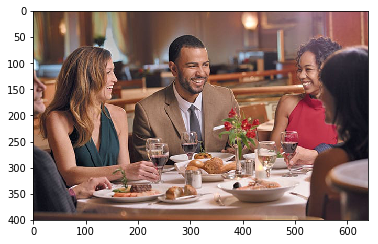

In [10]:
tokenized_list, img_name = upload_image()
print(tokenized_list)
my_list = stemmer(tokenized_list, img_name)


In [ ]:
def stemmer_query(tokenized_list):
    ps = SnowballStemmer("english")
    review = [ps.stem(word) for word in tokenized_list if not word in set(stopwords.words('english'))]
    return review

In [ ]:
def tokenize_and_remove_stop_words(document):
    characters = " .,!#$%^&*();:\n\t\\\"?!{}[]<>"
    ps = SnowballStemmer("english")
    terms = document.lower().split()
    term = [term.strip(characters) for term in terms]
    review = stemmer_query(term)
    for i in range(len(review)):
        if review[i] == 'surf':
            review[i] = 'surfboard'
        if review[i] == 'skate':
            review[i] = 'skateboard'
    return review           

In [ ]:
def returing_search_images(query): #returns all the images which matched with the query
    return_images = []
    with open('storage_file') as f:
        for line in f:
            if line.rstrip(): 
                my_list.update(json.loads(line))
    for k,v in my_list.items():
        print(v)
        if all(elem in v for elem in query):
            return_images.append(k)
    return return_images

In [ ]:
def query_given():
    query = input('Ask:')
    return returing_search_images(tokenize_and_remove_stop_words(query))

In [ ]:
query_given()